<a href="https://colab.research.google.com/github/daniel-sjkdm/ConsumingAPIs/blob/master/CountriesAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Countries API

The following notebook is an analysis of the countries API using:

+ pandas
+ searborn
+ matplotlib
+ requests

This is for practicing the data analysis skills! And also how it relates to get
data from different sources. Here the source of data is a free REST API that doesn't need authentication in order to be used.

## Source

 [Countries API](https://restcountries.eu/)

In [ ]:
import pandas as pd
import requests 
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import json
from pprint import pprint

In [ ]:
sns.set_theme()
matplotlib.rc('figure', figsize=(10, 5))

In [ ]:
base_url = "https://restcountries.eu/rest/v2"

In [ ]:
# Get all available information of the countries
r = requests.get(f"{base_url}/all")

if r.ok:
    data = r.json()
else:
    raise Exception("There was an error in the API server")

In [ ]:
# Which are the fields of the json object?
columns = list(data[0].keys())
pprint(columns)

['name',
 'topLevelDomain',
 'alpha2Code',
 'alpha3Code',
 'callingCodes',
 'capital',
 'altSpellings',
 'region',
 'subregion',
 'population',
 'latlng',
 'demonym',
 'area',
 'gini',
 'timezones',
 'borders',
 'nativeName',
 'numericCode',
 'currencies',
 'languages',
 'translations',
 'flag',
 'regionalBlocs',
 'cioc']


In [ ]:
# Since I'm only interested in a subset of columns, I'll filter the ones
# I don't want to appear 
columns_i_dont_want = ["alpha2Code", "alpha3Code", "callingCodes", "altSpellings",
                       "timezones", "borders", "nativeName", "numericCode",
                       "translations", "cioc"]

In [ ]:
# Since the response data is a list of json objects it must be parsed into 
# something useful and easy to read. That's why in here I'll
# extract with a map function only the fields of interest of the dict objects

new_data = []

for item in data:
    new_data.append(
      dict(
        name=item["name"],
        capital=item["capital"],
        region=item["region"],
        subregion=item["subregion"],
        population=item["population"],
        latlng=item["latlng"],
        area=item["area"],
        gini=item["gini"],
        currencies="".join(list(map(lambda field: str(field["name"]), item["currencies"]))),
        languages=list(map(lambda field: field["name"], item["languages"])),
        regionalBlocs=list(map(lambda field: field["name"], item["regionalBlocs"]))
      )
    )

# This is what the data looks like
df = pd.DataFrame(new_data)
df.head()

,name,capital,region,subregion,population,latlng,area,gini,currencies,languages,regionalBlocs
0,Afghanistan,Kabul,Asia,Southern Asia,27657145,"[33.0, 65.0]",652230.0,27.8,Afghan afghani,"[Pashto, Uzbek, Turkmen]",[South Asian Association for Regional Cooperat...
1,Åland Islands,Mariehamn,Europe,Northern Europe,28875,"[60.116667, 19.9]",1580.0,NaN,Euro,[Swedish],[European Union]
2,Albania,Tirana,Europe,Southern Europe,2886026,"[41.0, 20.0]",28748.0,34.5,Albanian lek,[Albanian],[Central European Free Trade Agreement]
3,Algeria,Algiers,Africa,Northern Africa,40400000,"[28.0, 3.0]",2381741.0,35.3,Algerian dinar,[Arabic],"[African Union, Arab League]"
4,American Samoa,Pago Pago,Oceania,Polynesia,57100,"[-14.33333333, -170.0]",199.0,NaN,United State Dollar,"[English, Samoan]",[]


In [ ]:
# Basic dataframe information

print(f"--- Shape = {df.shape}")

print(f"\n--- Datatypes = {df.dtypes}")

print("\n--- Are there null items?\n")

print(df.isnull().any())

--- Shape = (250, 11)

--- Datatypes = name              object
capital           object
region            object
subregion         object
population         int64
latlng            object
area             float64
gini             float64
currencies        object
languages         object
regionalBlocs     object
dtype: object

--- Are there null items?

name             False
capital          False
region           False
subregion        False
population       False
latlng           False
area              True
gini              True
currencies       False
languages        False
regionalBlocs    False
dtype: bool


In [ ]:
# Some fields have not valid values, let's drop them 
# to don't alter the analysis of the data
# Some rows get dropped (98)

df.dropna(inplace=True, how="any")
df.reset_index(inplace=True, drop=True)

print(f"Dataframe shape = {df.shape}")

df.head()

Dataframe shape = (152, 11)


,name,capital,region,subregion,population,latlng,area,gini,currencies,languages,regionalBlocs
0,Afghanistan,Kabul,Asia,Southern Asia,27657145,"[33.0, 65.0]",652230.0,27.8,Afghan afghani,"[Pashto, Uzbek, Turkmen]",[South Asian Association for Regional Cooperat...
1,Albania,Tirana,Europe,Southern Europe,2886026,"[41.0, 20.0]",28748.0,34.5,Albanian lek,[Albanian],[Central European Free Trade Agreement]
2,Algeria,Algiers,Africa,Northern Africa,40400000,"[28.0, 3.0]",2381741.0,35.3,Algerian dinar,[Arabic],"[African Union, Arab League]"
3,Angola,Luanda,Africa,Middle Africa,25868000,"[-12.5, 18.5]",1246700.0,58.6,Angolan kwanza,[Portuguese],[African Union]
4,Argentina,Buenos Aires,Americas,South America,43590400,"[-34.0, -64.0]",2780400.0,44.5,Argentine peso,"[Spanish, Guaraní]",[Union of South American Nations]


In [ ]:
df.describe()

,population,area,gini
count,1.520000e+02,1.520000e+02,152.000000
mean,4.627098e+07,8.210339e+05,40.207895
std,1.572678e+08,2.130387e+06,9.287901
min,9.140000e+04,3.000000e+02,24.000000
25%,4.096670e+06,5.058425e+04,33.625000
50%,1.060609e+07,2.112845e+05,38.750000
75%,3.151062e+07,6.205548e+05,46.400000
max,1.377422e+09,1.712444e+07,65.800000


In [ ]:
# Group the dataframe by region and sum their values
# The region with the most population is Asia

df.groupby("region").sum().sort_values(by="population", ascending=False)

,population,area,gini
region,,,
Asia,4222206657,28654042.0,1408.3
Africa,1057669811,24757886.0,2050.7
Americas,972749050,39931247.0,1315.0
Europe,742797914,23010371.0,1177.2
Oceania,37765914,8443603.0,160.4


In [ ]:
# Group by country, sum the numeric values of each group and then
# sort by population.
# This is how we can see China is the country with the highest 
# population and Seychelles is the country with the least

df.groupby("name").sum().sort_values(by="population", ascending=False)

,population,area,gini
name,,,
China,1377422166,9640011.0,47.0
India,1295210000,3287590.0,33.4
United States of America,323947000,9629091.0,48.0
Indonesia,258705000,1904569.0,34.0
Brazil,206135893,8515767.0,54.7
...,...,...,...
Belize,370300,22966.0,53.1
Maldives,344023,300.0,37.4
Sao Tome and Principe,187356,964.0,50.8


In [ ]:
# Group by gini and get the row with the highest value
# The gini index is a measure of the wealth distribution
# in a country. The lowest the value the better.

# Here we can see that the Seychelles country in Africa is
# the worst one in terms of this index

df_gini = df.groupby("gini").max().sort_values(by="gini", ascending=False)

df_gini.head()

,name,capital,region,subregion,population,latlng,area,currencies,languages,regionalBlocs
gini,,,,,,,,,,
65.8,Seychelles,Victoria,Africa,Eastern Africa,91400,"[-4.58333333, 55.66666666]",452.0,Seychellois rupee,"[French, English]",[African Union]
64.3,Comoros,Moroni,Africa,Eastern Africa,806153,"[-12.16666666, 44.25]",1862.0,Comorian franc,"[Arabic, French]","[African Union, Arab League]"
63.9,Namibia,Windhoek,Africa,Southern Africa,2324388,"[-22.0, 17.0]",825615.0,Namibian dollarSouth African rand,"[English, Afrikaans]",[African Union]
63.1,South Africa,Pretoria,Africa,Southern Africa,55653654,"[-29.0, 24.0]",1221037.0,South African rand,"[Afrikaans, English, Southern Ndebele, Souther...",[African Union]
61.0,Botswana,Gaborone,Africa,Southern Africa,2141206,"[-22.0, 24.0]",582000.0,Botswana pula,"[English, Tswana]",[African Union]


In [ ]:
# Group by currencies and display the ones that uses Euro 

df.groupby("currencies").get_group("Euro").reset_index(drop=True)

,name,capital,region,subregion,population,latlng,area,gini,currencies,languages,regionalBlocs
0,Austria,Vienna,Europe,Western Europe,8725931,"[47.33333333, 13.33333333]",83871.0,26.0,Euro,[German],[European Union]
1,Belgium,Brussels,Europe,Western Europe,11319511,"[50.83333333, 4.0]",30528.0,33.0,Euro,"[Dutch, French, German]",[European Union]
2,Estonia,Tallinn,Europe,Northern Europe,1315944,"[59.0, 26.0]",45227.0,36.0,Euro,[Estonian],[European Union]
3,Finland,Helsinki,Europe,Northern Europe,5491817,"[64.0, 26.0]",338424.0,26.9,Euro,"[Finnish, Swedish]",[European Union]
4,France,Paris,Europe,Western Europe,66710000,"[46.0, 2.0]",640679.0,32.7,Euro,[French],[European Union]
5,Germany,Berlin,Europe,Western Europe,81770900,"[51.0, 9.0]",357114.0,28.3,Euro,[German],[European Union]
6,Greece,Athens,Europe,Southern Europe,10858018,"[39.0, 22.0]",131990.0,34.3,Euro,[Greek (modern)],[European Union]
7,Ireland,Dublin,Europe,Northern Europe,6378000,"[53.0, -8.0]",70273.0,34.3,Euro,"[Irish, English]",[European Union]
8,Italy,Rome,Europe,Southern Europe,60665551,"[42.83333333, 12.83333333]",301336.0,36.0,Euro,[Italian],[European Union]
9,Latvia,Riga,Europe,Northern Europe,1961600,"[57.0, 25.0]",64559.0,36.6,Euro,[Latvian],[European Union]


In [ ]:
# This is the same as above

df[df["currencies"] == "Euro"].reset_index()

,index,name,capital,region,subregion,population,latlng,area,gini,currencies,languages,regionalBlocs
0,7,Austria,Vienna,Europe,Western Europe,8725931,"[47.33333333, 13.33333333]",83871.0,26.0,Euro,[German],[European Union]
1,11,Belgium,Brussels,Europe,Western Europe,11319511,"[50.83333333, 4.0]",30528.0,33.0,Euro,"[Dutch, French, German]",[European Union]
2,42,Estonia,Tallinn,Europe,Northern Europe,1315944,"[59.0, 26.0]",45227.0,36.0,Euro,[Estonian],[European Union]
3,45,Finland,Helsinki,Europe,Northern Europe,5491817,"[64.0, 26.0]",338424.0,26.9,Euro,"[Finnish, Swedish]",[European Union]
4,46,France,Paris,Europe,Western Europe,66710000,"[46.0, 2.0]",640679.0,32.7,Euro,[French],[European Union]
5,49,Germany,Berlin,Europe,Western Europe,81770900,"[51.0, 9.0]",357114.0,28.3,Euro,[German],[European Union]
6,51,Greece,Athens,Europe,Southern Europe,10858018,"[39.0, 22.0]",131990.0,34.3,Euro,[Greek (modern)],[European Union]
7,65,Ireland,Dublin,Europe,Northern Europe,6378000,"[53.0, -8.0]",70273.0,34.3,Euro,"[Irish, English]",[European Union]
8,67,Italy,Rome,Europe,Southern Europe,60665551,"[42.83333333, 12.83333333]",301336.0,36.0,Euro,[Italian],[European Union]
9,75,Latvia,Riga,Europe,Northern Europe,1961600,"[57.0, 25.0]",64559.0,36.6,Euro,[Latvian],[European Union]


In [ ]:
# Display the frequency of the currencies as a percentage
# The Euro is the most used as national currency by 11.84 
# percent of the countries (listed in the dataset)

df["currencies"].value_counts(normalize=True).sort_values(ascending=False)

Euro                         0.118421
West African CFA franc       0.052632
Central African CFA franc    0.032895
United States dollar         0.019737
Macedonian denar             0.006579
                               ...   
Guatemalan quetzal           0.006579
Venezuelan bolívar           0.006579
Turkmenistan manat           0.006579
East Caribbean dollar        0.006579
Canadian dollar              0.006579
Name: currencies, Length: 122, dtype: float64

In [ ]:
# Get information about Mexico!

df_mexico = df[df["name"] == "Mexico"]
df_mexico

,name,capital,region,subregion,population,latlng,area,gini,currencies,languages,regionalBlocs
87,Mexico,Mexico City,Americas,Central America,122273473,"[23.0, -102.0]",1964375.0,47.0,Mexican peso,[Spanish],"[Pacific Alliance, North American Free Trade A..."


## Interesting groups

Groups subsets are created here to be analyzed by:

+ population
+ gini index

In [ ]:
region_group = df.groupby("region")
subregion_group = df.groupby("subregion")
population_group = df.groupby("population")
currencies_group = df.groupby("currencies")

### Population statistics

In [ ]:
# Average population per region

region_group["population"].mean().sort_values(ascending=True)

region
Oceania     9.441478e+06
Europe      2.007562e+07
Africa      2.299282e+07
Americas    3.602774e+07
Asia        1.111107e+08
Name: population, dtype: float64

In [ ]:
# Average population per subregion
# In average, Eastern Asia is the most populated region of Asia
# In America, the most populated subregion in average is Northern America

subregion_group["population"].mean().sort_values(ascending=False)

subregion
Eastern Asia                 3.131202e+08
Southern Asia                2.008762e+08
Northern America             1.800512e+08
South-Eastern Asia           6.447099e+07
Northern Africa              4.315613e+07
South America                3.486248e+07
Eastern Europe               2.936036e+07
Western Europe               2.778056e+07
Eastern Africa               2.565868e+07
Western Africa               2.388305e+07
Central America              2.111061e+07
Western Asia                 1.997586e+07
Australia and New Zealand    1.440761e+07
Central Asia                 1.374442e+07
Southern Europe              1.370596e+07
Southern Africa              1.262922e+07
Northern Europe              1.155165e+07
Middle Africa                1.086682e+07
Caribbean                    5.082398e+06
Melanesia                    4.475350e+06
Name: population, dtype: float64

In [ ]:
# Here's the average population for currencies

currencies_group["population"].mean().sort_values(ascending=False).head()

currencies
Chinese yuan         1.377422e+09
Indian rupee         1.295210e+09
Indonesian rupiah    2.587050e+08
Brazilian real       2.061359e+08
Pakistani rupee      1.941251e+08
Name: population, dtype: float64

### Gini index statistics

In [ ]:
# By region, in average Europe has the best gini index

region_group["gini"].mean().sort_values(ascending=False)

region
Americas    48.703704
Africa      44.580435
Oceania     40.100000
Asia        37.060526
Europe      31.816216
Name: gini, dtype: float64

In [ ]:
# By population, in average the best gini index is in a population
# of 5717014 persons

population_group["gini"].mean().sort_values(ascending=False).tail()

population
8725931     26.0
10558524    26.0
5223256     25.8
9894888     25.0
5717014     24.0
Name: gini, dtype: float64

In [ ]:
# By currency, the best gini index is hold by the Europeans countries
# that uses Euro 

currencies_group["gini"].mean().sort_values(ascending=False).tail()

currencies
Ukrainian hryvnia    26.4
Czech koruna         26.0
Norwegian krone      25.8
Swedish krona        25.0
Danish krone         24.0
Name: gini, dtype: float64

## Plotting

Since all the countries are listed, to display some plots I'm only using a subset of them to make it visually clear.

In [ ]:
height = 8
aspect = 1.5

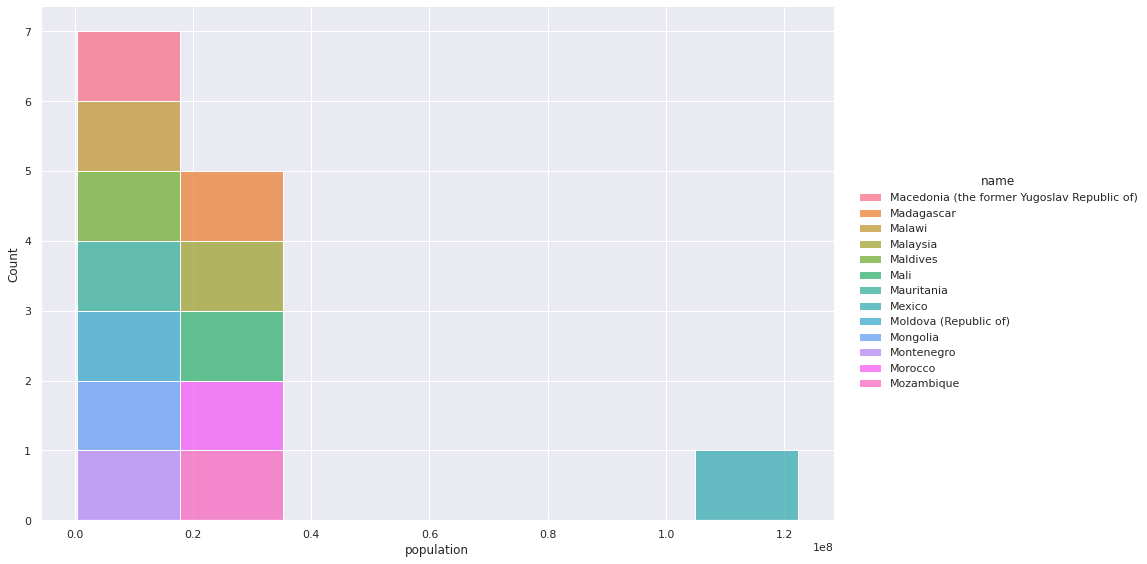

In [ ]:
# Let's plot the population in countries that begins with letter C

sns.displot(data=df.loc[df["name"].str.startswith("M", na=False)], 
            x="population", hue="name", multiple="stack", 
            height=height, aspect=aspect)

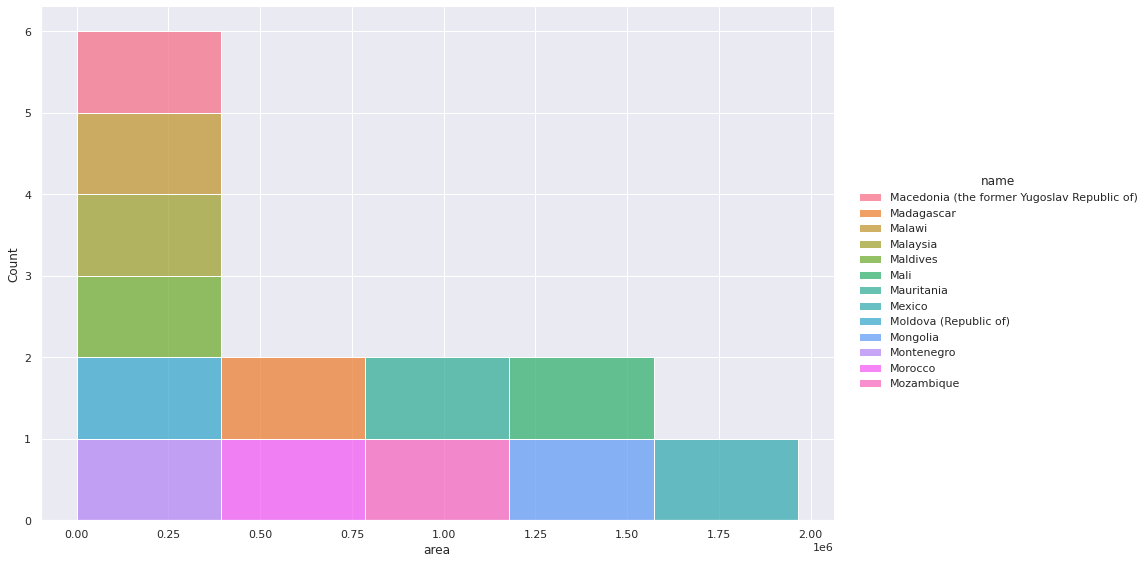

In [ ]:
# Plot the area of the countries starting with M

sns.displot(data=df[df["name"].str.startswith("M", na=False)], x="area", 
            hue="name", multiple="stack", height=8, aspect=aspect)

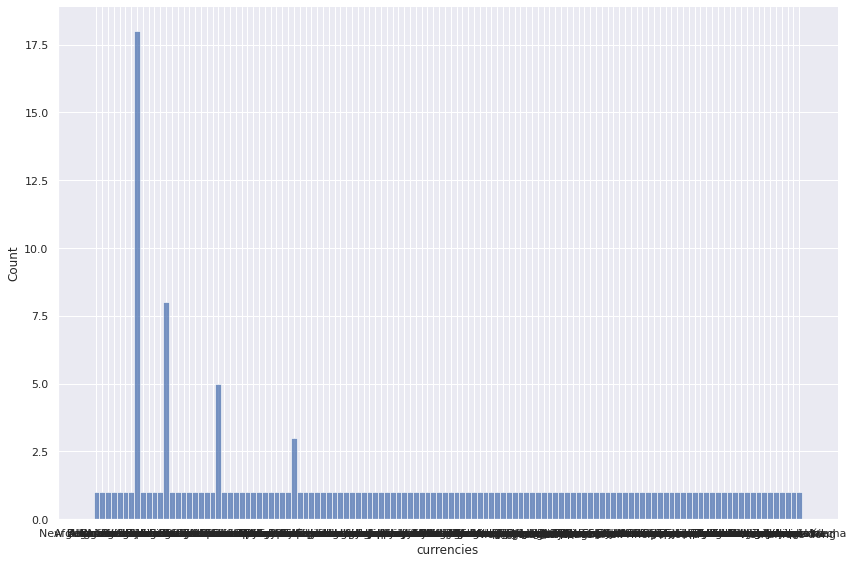

In [ ]:
# Plot the frequency distribution of the currencies

sns.displot(data=df, x="currencies", height=height, aspect=aspect, 
            multiple="stack")

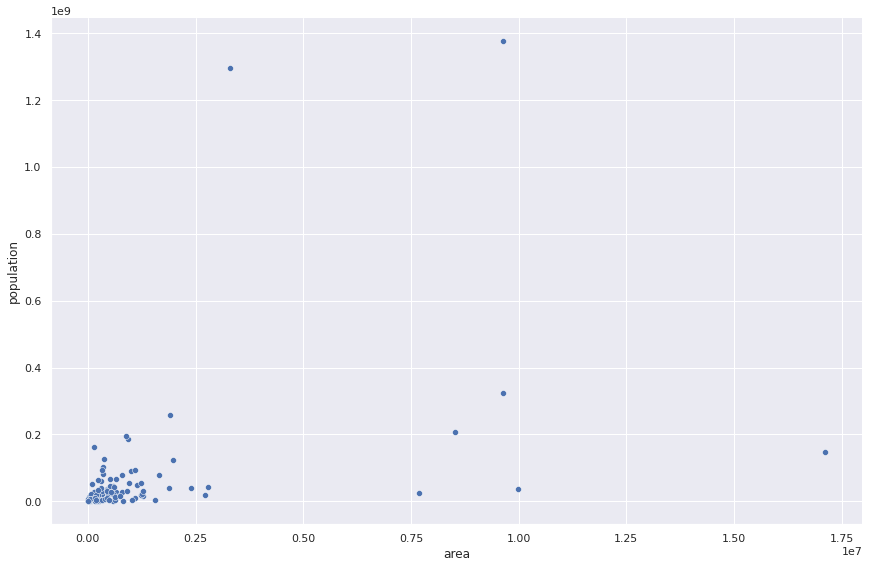

In [ ]:
# Plot the relationship between population and area
# Most of the population are centered in smaller areas

sns.relplot(data=df, x="area", y="population", height=height, aspect=aspect)

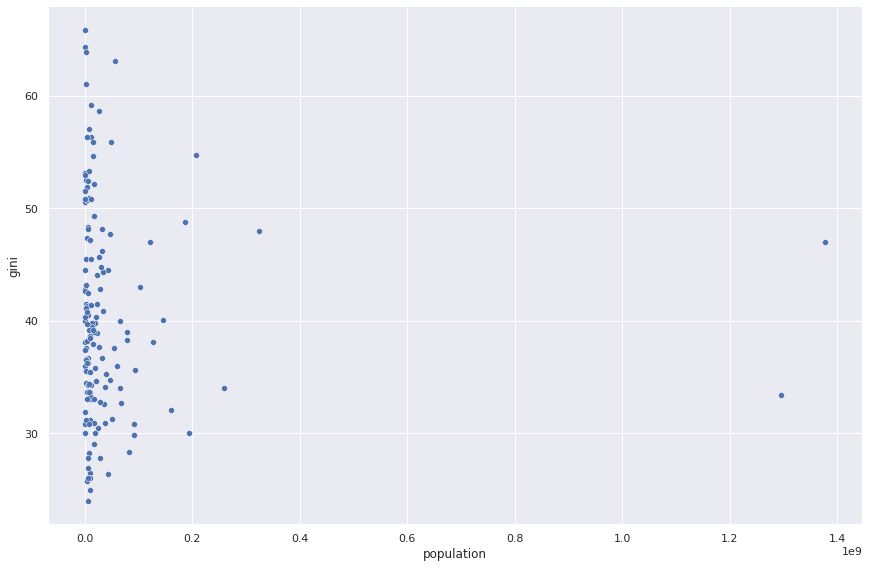

In [ ]:
# Relationship between gini index and population
# Theres no correlation between the index and population
# since in smaller populations there are both high and low
# gini index values

sns.relplot(data=df, x="population", y="gini", height=height, aspect=aspect)

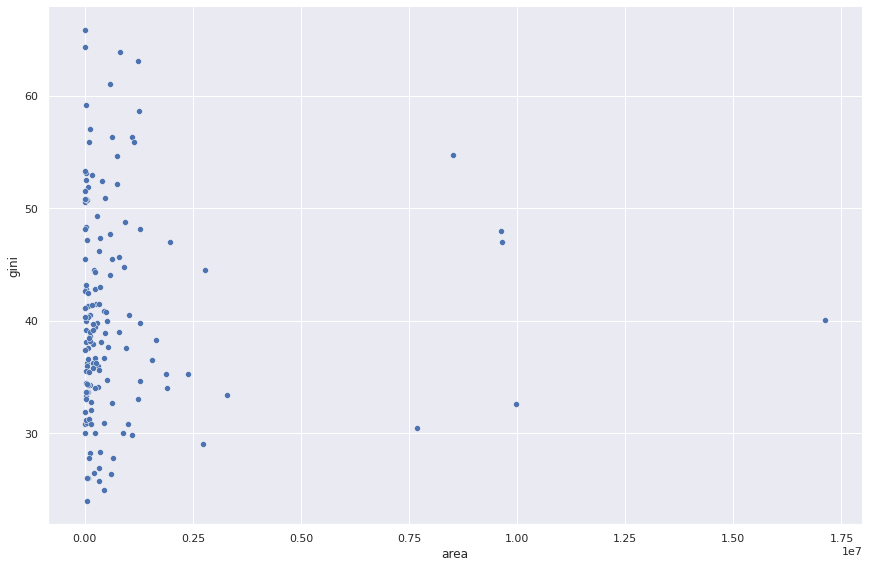

In [ ]:
sns.relplot(data=df, x="area", y="gini", height=height, aspect=aspect)

In [ ]:
currencies_group = df.groupby("currencies")
currencies_group["population"].value_counts().head(10)

currencies         population
Afghan afghani     27657145      1
Albanian lek       2886026       1
Algerian dinar     40400000      1
Angolan kwanza     25868000      1
Argentine peso     43590400      1
Armenian dram      2994400       1
Australian dollar  24117360      1
Azerbaijani manat  9730500       1
Bangladeshi taka   161006790     1
Belize dollar      370300        1
Name: population, dtype: int64

In [ ]:
currencies_group.get_group("Euro")

,name,capital,region,subregion,population,latlng,area,gini,currencies,languages,regionalBlocs
7,Austria,Vienna,Europe,Western Europe,8725931,"[47.33333333, 13.33333333]",83871.0,26.0,Euro,[German],[European Union]
11,Belgium,Brussels,Europe,Western Europe,11319511,"[50.83333333, 4.0]",30528.0,33.0,Euro,"[Dutch, French, German]",[European Union]
42,Estonia,Tallinn,Europe,Northern Europe,1315944,"[59.0, 26.0]",45227.0,36.0,Euro,[Estonian],[European Union]
45,Finland,Helsinki,Europe,Northern Europe,5491817,"[64.0, 26.0]",338424.0,26.9,Euro,"[Finnish, Swedish]",[European Union]
46,France,Paris,Europe,Western Europe,66710000,"[46.0, 2.0]",640679.0,32.7,Euro,[French],[European Union]
49,Germany,Berlin,Europe,Western Europe,81770900,"[51.0, 9.0]",357114.0,28.3,Euro,[German],[European Union]
51,Greece,Athens,Europe,Southern Europe,10858018,"[39.0, 22.0]",131990.0,34.3,Euro,[Greek (modern)],[European Union]
65,Ireland,Dublin,Europe,Northern Europe,6378000,"[53.0, -8.0]",70273.0,34.3,Euro,"[Irish, English]",[European Union]
67,Italy,Rome,Europe,Southern Europe,60665551,"[42.83333333, 12.83333333]",301336.0,36.0,Euro,[Italian],[European Union]
75,Latvia,Riga,Europe,Northern Europe,1961600,"[57.0, 25.0]",64559.0,36.6,Euro,[Latvian],[European Union]


In [ ]:
# Get gini index by each region

region_group = df.groupby("region")
region_group["population"].value_counts().loc["Africa"]
# region_group.get_group("Africa")

population
91400        1
187356       1
531239       1
806153       1
900000       1
1132657      1
1547777      1
1802278      1
1894194      1
2141206      1
2324388      1
3718678      1
4615000      1
4741000      1
4998000      1
7075641      1
7143000      1
10114505     1
10653654     1
11154400     1
11553188     1
12131000     1
12947000     1
14497000     1
14799859     1
15933883     1
16832910     1
18135000     1
19034397     1
20715000     1
22434363     1
22671331     1
22709892     1
25868000     1
26423700     1
27670174     1
33337529     1
33860700     1
39598700     1
40400000     1
47251000     1
55155000     1
55653654     1
91290000     1
92206005     1
186988000    1
Name: population, dtype: int64

In [ ]:
currencies_group["population"].value_counts()

currencies              population
Afghan afghani          27657145      1
Albanian lek            2886026       1
Algerian dinar          40400000      1
Angolan kwanza          25868000      1
Argentine peso          43590400      1
                                     ..
West African CFA franc  19034397      1
                        20715000      1
                        22671331      1
Yemeni rial             27478000      1
Zambian kwacha          15933883      1
Name: population, Length: 152, dtype: int64

In [ ]:
filter = df["currencies"] == "United States dollar"
df.loc[filter]

,name,capital,region,subregion,population,latlng,area,gini,currencies,languages,regionalBlocs
39,Ecuador,Quito,Americas,South America,16545799,"[-2.0, -77.5]",276841.0,49.3,United States dollar,[Spanish],[Union of South American Nations]
41,El Salvador,San Salvador,Americas,Central America,6520675,"[13.83333333, -88.91666666]",21041.0,48.3,United States dollar,[Spanish],[Central American Integration System]
145,United States of America,"Washington, D.C.",Americas,Northern America,323947000,"[38.0, -97.0]",9629091.0,48.0,United States dollar,[English],[North American Free Trade Agreement]
